# Support Vector Machines

In this notebook, we are going to understand how SVM work and how to apply such a model in python


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy import stats

/var/folders/vm/01c_nbj93wj1_93nt97yz55h0000gn/T/ipykernel_40663/483161010.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Understanding SVM

In this example, we consider the simple case of a classification task in which the two classes of points are well separated (see the following figure):

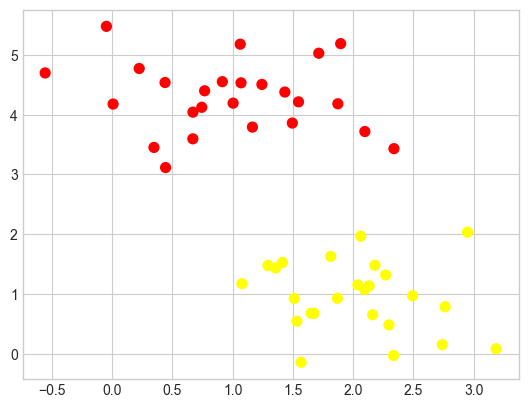

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

The idea is to find the separating hyperplane. In this case we want to find the line that can separate the 2 classes

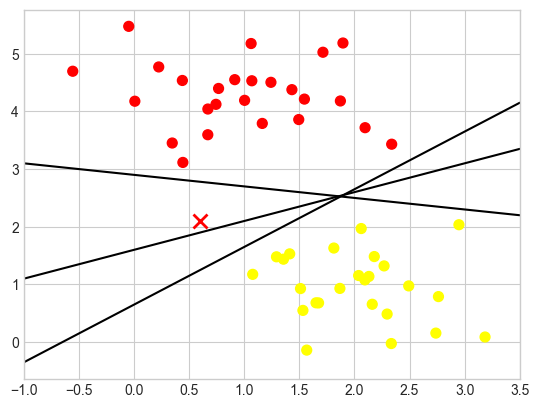

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not good enough, and we need to think a bit more deeply.

## Support Vector Machines: Maximizing the Margin

How can we choose the lne that separates between the data?\
=> Find the line that maximizes the margins 

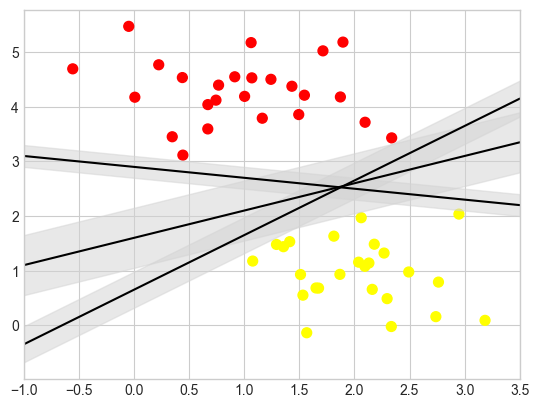

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgray', alpha=0.5)

plt.xlim(-1, 3.5);

### Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier (`SVC`) to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily):

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us (see the following figure):

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

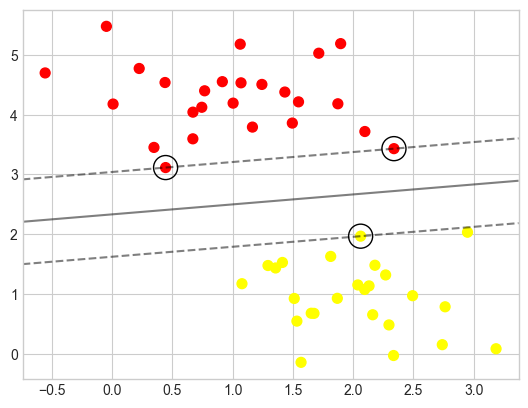

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.

In Scikit-Learn, the identities of these points are stored in the `support_vectors_` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors in the left panel are the same as the support vectors in the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=(10, 200), ax=fixed(None));

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

## Beyond Linear Boundaries: Kernel SVM

Where SVM can become quite powerful is when it is combined with *kernels*.

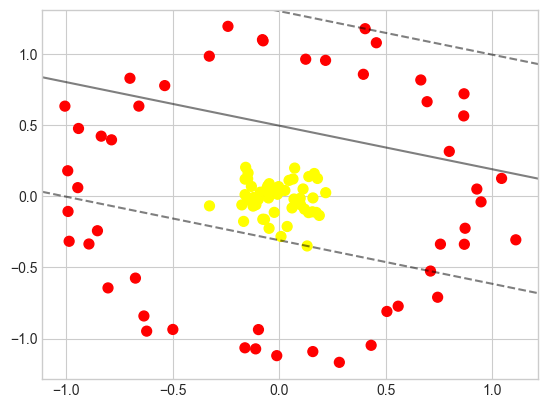

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

We can visualize this extra data dimension using a three-dimensional plot, as seen in the following figure:

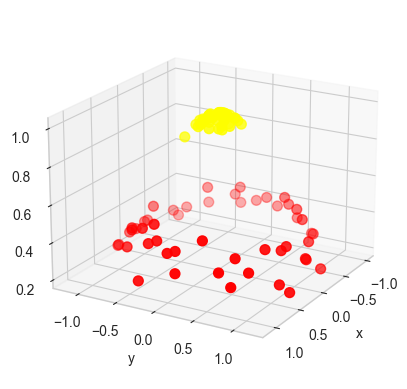

In [12]:
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF kernel, using the `kernel` model hyperparameter:

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

Let's use our previously defined function to visualize the fit and identify the support vectors (see the following figure):

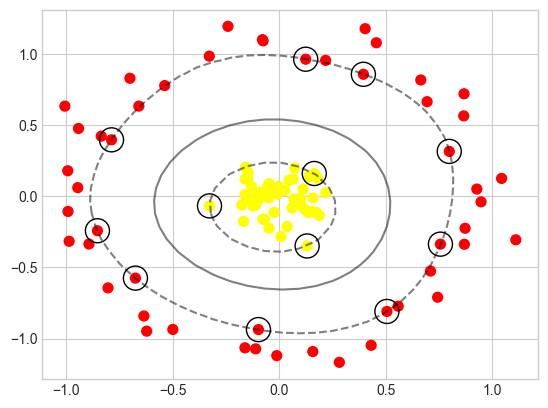

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### Tuning the SVM: Softening Margins

Above we have only seen separable data. What if the separating hyperplane is not clearly defined?

For example, you may have data like this (see the following figure):

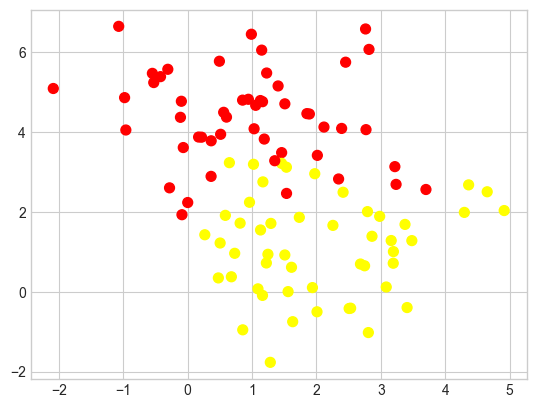

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

The hardness of the margin is controlled by a tuning parameter, most often known as `C`.
For a very large `C`, the margin is hard, and points cannot lie in it.
For a smaller `C`, the margin is softer and can grow to encompass some points.

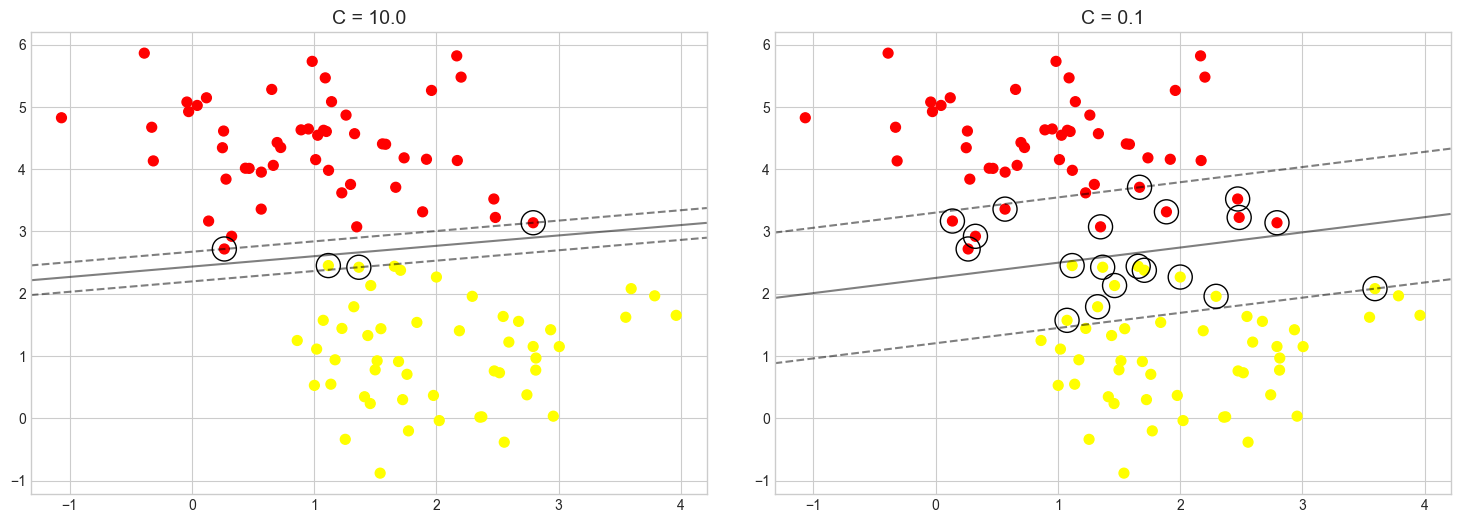

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of `C` will depend on your dataset, and you should tune this parameter using cross-validation or a similar procedure

## Classifier comparison

Let's try to see how different classifiers deal with different datasets 

In [21]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

In [22]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Polynomial kerne SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(kernel='rbf',gamma=2, C=1, random_state=42),
    SVC(kernel='poly', random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    AdaBoostClassifier(random_state=42),
]


In [23]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,]

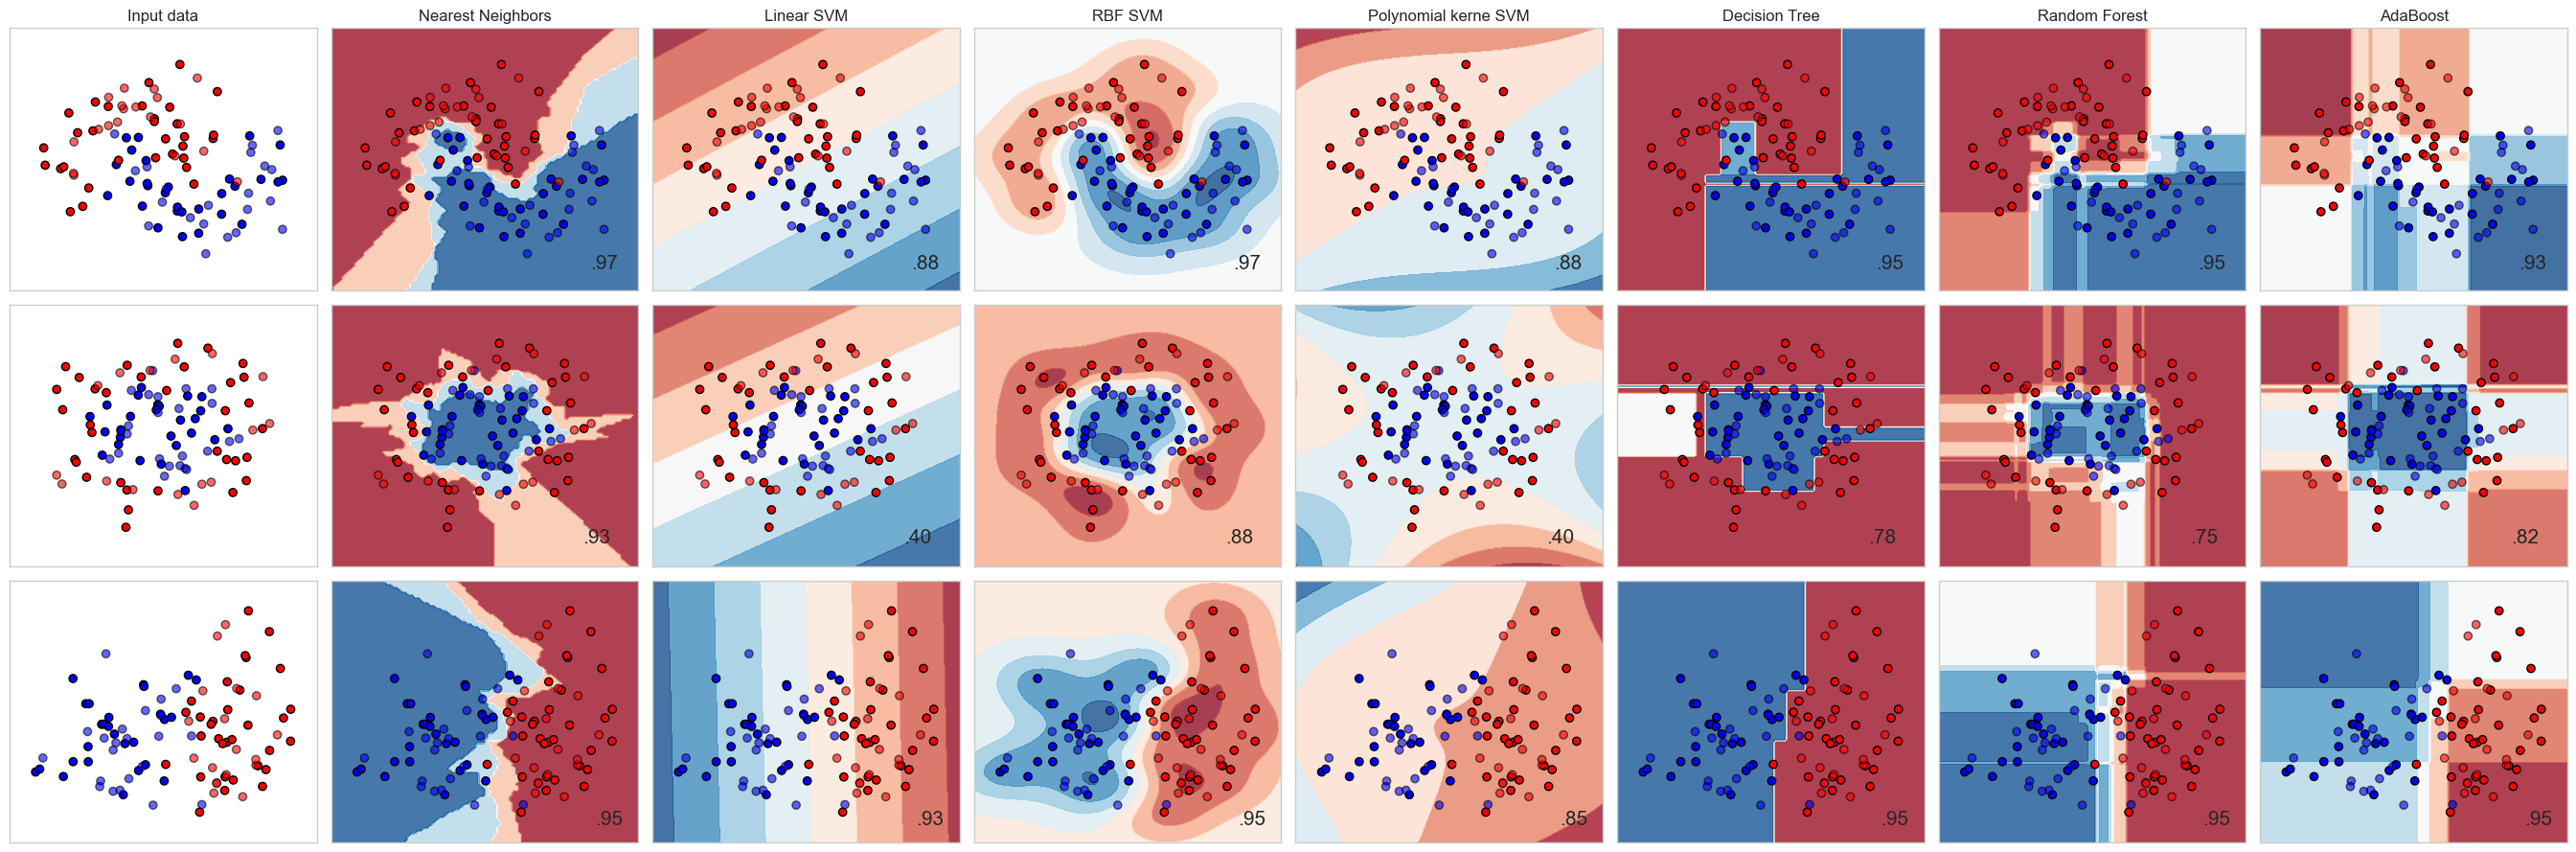

In [24]:


figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [25]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with (see the following figure):

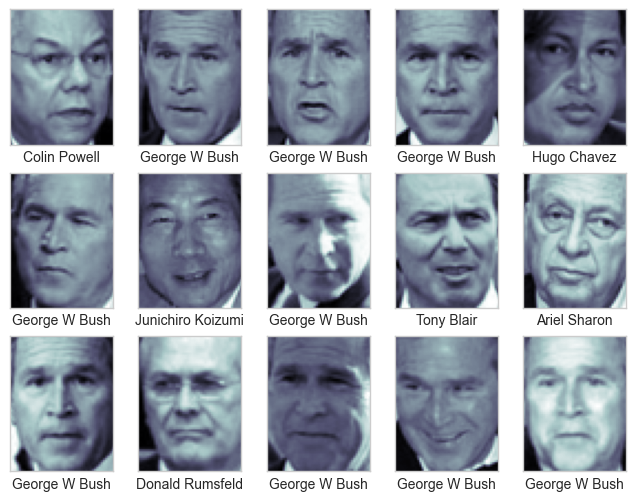

In [26]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains 62 × 47, or around 3,000, pixels.

We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use principal component analysis  to extract 150 fundamental components to feed into our support vector machine classifier.

We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [27]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training set and a testing set:

In [28]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 26s, sys: 37.8 s, total: 2min 4s
Wall time: 32.1 s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model we can predict the labels for the test data, which the model has not yet seen:

In [30]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values (see the following figure):

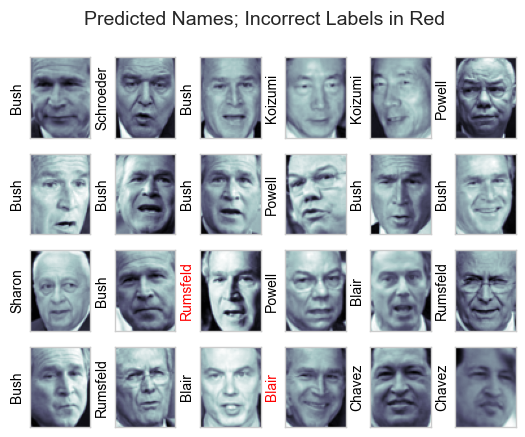

In [31]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [32]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes (see the following figure):

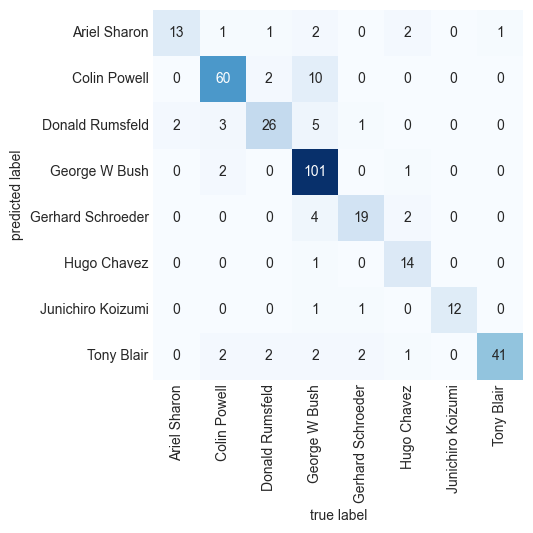

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

### -  References:

1 - This note is entirely taken from https://github.com/jakevdp/PythonDataScienceHandbook/tree/master. All credit goes to Jake VanderPlas 

2 - https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py